## Packages

In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import math
from datetime import datetime
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

In [23]:
 # Ensure project root (with src/) is on sys.path so imports like `from src...` work in notebooks
import sys
from pathlib import Path
p = Path.cwd()
for _ in range(6):
    if (p / 'pyproject.toml').exists():
        project_root = p
        break
    if p.parent == p:
        project_root = Path.cwd()
        break
    p = p.parent
else:
    project_root = Path.cwd()
# Insert at front so local src/ takes precedence
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
print(f'Added project root to sys.path: {project_root}')

Added project root to sys.path: c:\Users\nicov\Documents\Projects\stock-predictor


## Input Parameters

In [17]:
ticker = "FUR.AS"
start_date = "2019-01-01"
rsi_period = 14
periods = [20, 50, 200]
start_plot_date = "2025-01-01"
df = yf.download(ticker, start=start_date, interval="1d")
close_df = df[['Close']].copy()

C:\Users\nicov\AppData\Local\Temp\ipykernel_21100\2889443880.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, interval="1d")
[*********************100%***********************]  1 of 1 completed


## RSI calculation function / coding

In [ ]:
# obsolete cell

## RSI , EMA/SMA plotting

In [24]:
from src.calculate_rsi import calculate_rsi

def plot_price_with_indicators(df, ticker, indicator_type="both", periods=[20, 50, 200], rsi_period=14, start_plot_date=start_plot_date):
    """
    Plot de prijs van een aandeel met SMA, EMA en RSI.
    
    Parameters:
    - df: DataFrame met een 'Close'-kolom
    - ticker: string (naam van het aandeel)
    - indicator_type: 'sma', 'ema' of 'both'
    - periods: lijst met periodes (default [20, 50, 200])
    - rsi_period: periode voor RSI (default 14)
    - start_plot_date: optionele startdatum (YYYY-MM-DD)
    """

    close_df = df[['Close']].copy()

    # ---- SMA ----
    if indicator_type in ["sma", "both"]:
        for p in periods:
            close_df[f'SMA{p}'] = close_df['Close'].rolling(window=p).mean()

    # ---- EMA ----
    if indicator_type in ["ema", "both"]:
        for p in periods:
            close_df[f'EMA{p}'] = close_df['Close'].ewm(span=p, adjust=False).mean()

    # ---- RSI ----
    close_df['RSI'] = calculate_rsi(close_df, rsi_period)

    # ---- Data filteren vanaf startdatum ----
    if start_plot_date is not None:
        plot_df = close_df[close_df.index >= pd.to_datetime(start_plot_date)].copy()
    else:
        plot_df = close_df.copy()

    # ---- Plot setup ----
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(14, 8),
        sharex=True,
        gridspec_kw={'height_ratios': [2.5, 1]}
    )

    colors = {20: "green", 50: "red", 200: "black"}

    # ---- Prijs + MAs ----
    ax1.plot(plot_df.index, plot_df['Close'], color='blue', label='Close', linewidth=1.6)

    if indicator_type in ["sma", "both"]:
        for p in periods:
            col = f'SMA{p}'
            if col in plot_df.columns:
                ax1.plot(plot_df.index, plot_df[col], color=colors.get(p, 'gray'), label=col, linewidth=1.2)

    if indicator_type in ["ema", "both"]:
        for p in periods:
            col = f'EMA{p}'
            if col in plot_df.columns:
                ax1.plot(plot_df.index, plot_df[col], color=colors.get(p, 'gray'),
                         label=col, linewidth=1.2, linestyle='--')

    # ---- Layout prijsplot ----
    ax1.set_title(f"{ticker} — Price Chart ({indicator_type.upper()}) + RSI", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Price", fontsize=11)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.legend(loc='upper left', fontsize=9)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.yaxis.get_major_formatter().set_scientific(False)

    # ---- RSI-plot ----
    ax2.plot(plot_df.index, plot_df['RSI'], label=f'RSI ({rsi_period})', color='purple', linewidth=1.4)
    ax2.axhline(70, color='red', linestyle='--', linewidth=1)
    ax2.axhline(30, color='green', linestyle='--', linewidth=1)
    ax2.fill_between(plot_df.index, 70, 30, color='gray', alpha=0.1)
    ax2.set_ylabel("RSI")
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.yaxis.get_major_formatter().set_scientific(False)
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.legend(loc='upper left', fontsize=9)

    plt.tight_layout(pad=1)
    plt.show()


## Plot with EMA / SMA

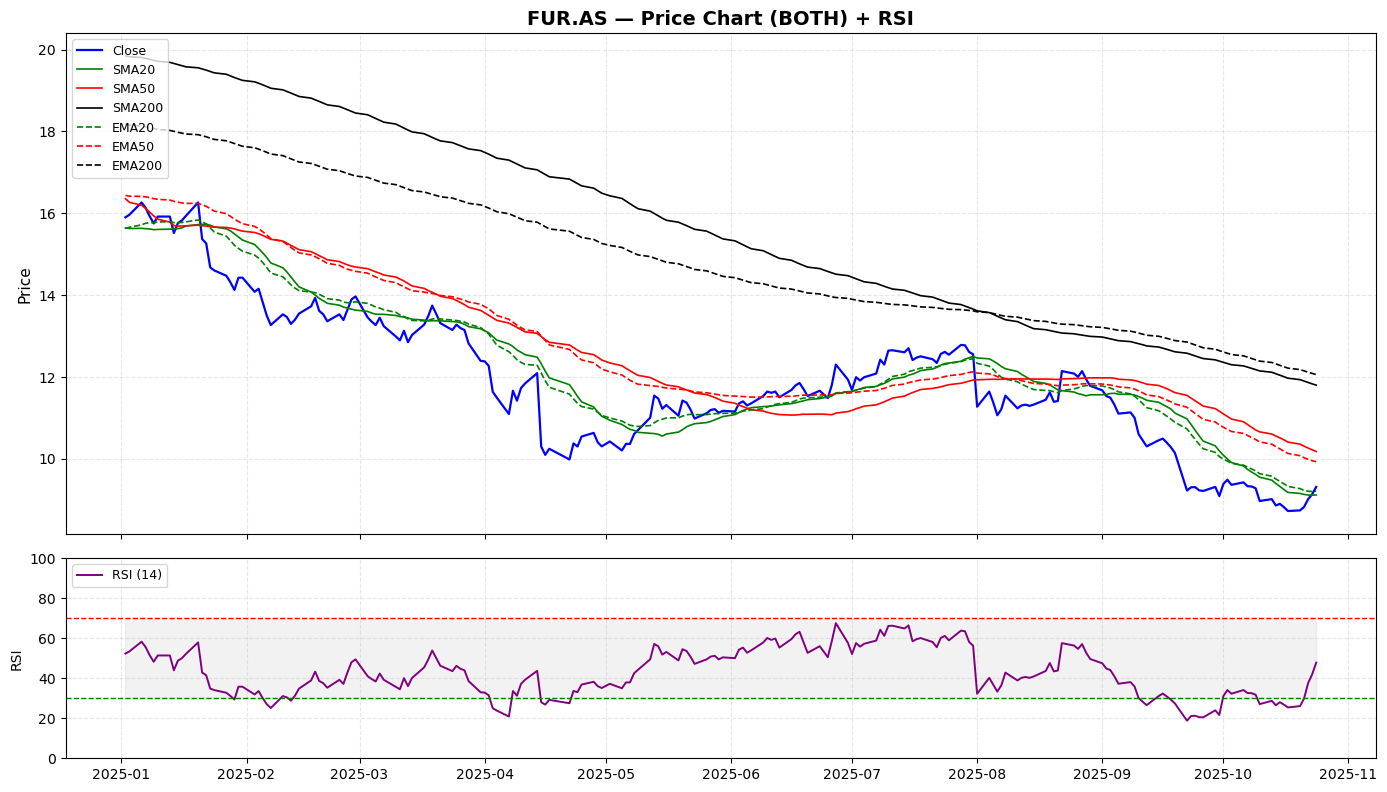

In [5]:
plot_price_with_indicators(df, ticker, indicator_type="both")

## Bollinger Coding

In [6]:
def plot_bollinger_bands(df, ticker, period=20, std_dev=2, start_plot_date=None):
    """
    Bereken en plot Bollinger Bands.
    - Berekent alleen data vanaf (start_plot_date - period dagen)
    - Plot vanaf 'start_plot_date'
    """
    df = df.copy()

    # === Bereken hoeveel extra dagen we nodig hebben ===
    if start_plot_date is not None:
        start_plot_date = pd.to_datetime(start_plot_date)
        buffer_start_date = start_plot_date - pd.Timedelta(days=period * 2)
        # kleine veiligheidsmarge: *2 omdat markten niet elke dag open zijn
        df = df.loc[df.index >= buffer_start_date]
    
    # === Bollinger Bands berekenen ===
    df['BB_Middle'] = df['Close'].rolling(window=period).mean()
    df['BB_Std'] = df['Close'].rolling(window=period).std()
    df['BB_Upper'] = df['BB_Middle'] + (df['BB_Std'] * std_dev)
    df['BB_Lower'] = df['BB_Middle'] - (df['BB_Std'] * std_dev)

    # === Plot filter ===
    if start_plot_date is not None:
        df_plot = df.loc[df.index >= start_plot_date]
    else:
        df_plot = df.copy()

    # === Plot ===
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(df_plot.index, df_plot['Close'], color='blue', label='Close', linewidth=1.6)
    ax.plot(df_plot.index, df_plot['BB_Middle'], color='orange', label=f'SMA{period}', linewidth=1.2)
    ax.plot(df_plot.index, df_plot['BB_Upper'], color='green', label='Upper Band', linewidth=1.2, linestyle='--')
    ax.plot(df_plot.index, df_plot['BB_Lower'], color='red', label='Lower Band', linewidth=1.2, linestyle='--')
    ax.fill_between(df_plot.index, df_plot['BB_Upper'], df_plot['BB_Lower'], color='gray', alpha=0.1)

    ax.set_title(f"{ticker} — Bollinger Bands (Period: {period}, Std Dev: {std_dev})", fontsize=14, fontweight='bold')
    ax.set_ylabel("Price", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)
    ax.tick_params(axis='y', labelcolor='black')
    ax.yaxis.get_major_formatter().set_scientific(False)

    plt.tight_layout(pad=1)
    plt.show()

## Bollinger Plot

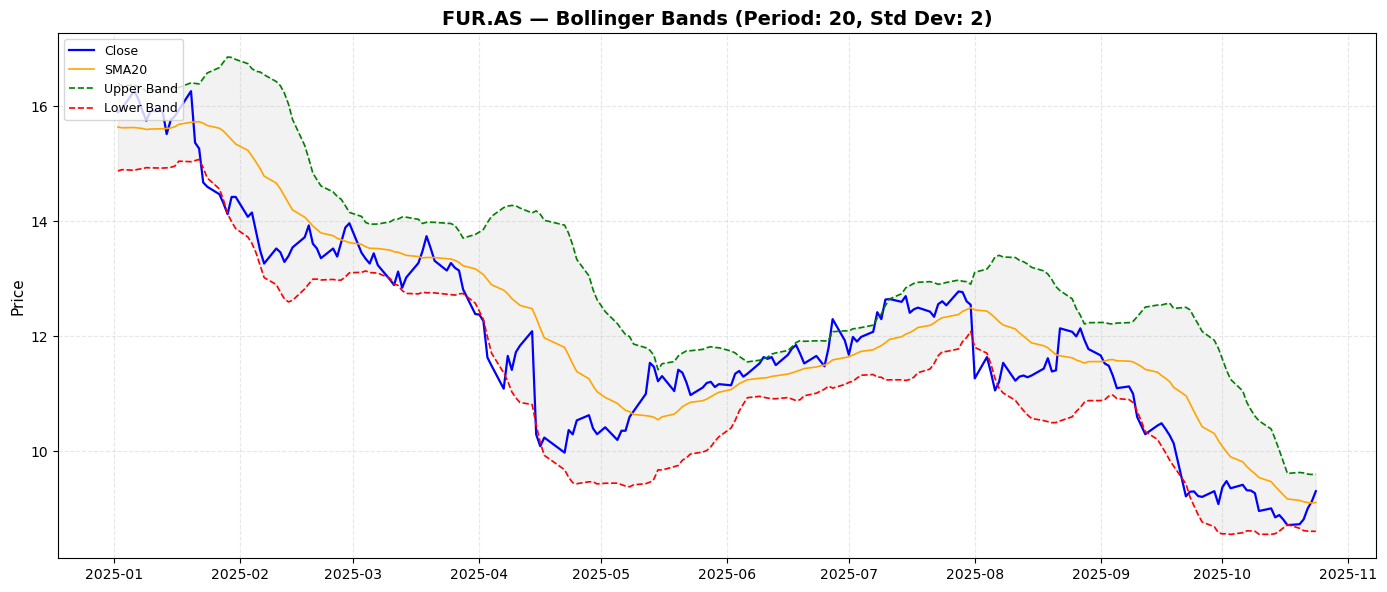

In [7]:
 plot_bollinger_bands(df, ticker, period=20, std_dev=2, start_plot_date=start_plot_date)

## SMA, EMA, BB Coding

In [8]:
def print_technische_indicatoren(df, bb_period=20, bb_std_dev=2, periods=periods):
    """
    Print de laatste waarden van SMA, EMA en Bollinger Bands uit een DataFrame.
    """
    df = df.copy()

    # === SMA & EMA berekenen ===
    for p in periods:
        df[f'SMA{p}'] = df['Close'].rolling(window=p).mean()
        df[f'EMA{p}'] = df['Close'].ewm(span=p, adjust=False).mean()

    # === Bollinger Bands berekenen ===
    df['BB_Middle'] = df['Close'].rolling(window=bb_period).mean()
    df['BB_Std'] = df['Close'].rolling(window=bb_period).std()
    df['BB_Upper'] = df['BB_Middle'] + (df['BB_Std'] * bb_std_dev)
    df['BB_Lower'] = df['BB_Middle'] - (df['BB_Std'] * bb_std_dev)

    # === Waarden printen ===
    laatste_datum = df.index[-1].strftime('%Y-%m-%d') if hasattr(df.index[-1], 'strftime') else df.index[-1]
    print(f"Laatste waarden voor alle indicatoren (datum: {laatste_datum}):")

    for p in periods:
        print(f"- SMA{p}: {df[f'SMA{p}'].iloc[-1]:.2f}")
        print(f"- EMA{p}: {df[f'EMA{p}'].iloc[-1]:.2f}")

    print(f"- BB_Upper: {df['BB_Upper'].iloc[-1]:.2f}")
    print(f"- BB_Middle: {df['BB_Middle'].iloc[-1]:.2f}")
    print(f"- BB_Lower: {df['BB_Lower'].iloc[-1]:.2f}")


## SMA, EMA, BB printing

In [9]:
SMA_EMA_BB = print_technische_indicatoren(close_df)

Laatste waarden voor alle indicatoren (datum: 2025-10-24):
- SMA20: 9.11
- EMA20: 9.21
- SMA50: 10.18
- EMA50: 9.92
- SMA200: 11.80
- EMA200: 12.06
- BB_Upper: 9.61
- BB_Middle: 9.11
- BB_Lower: 8.61


## MACD Coding

In [10]:
def plot_macd(df, ticker, start_plot_date=None, fast=12, slow=26, signal=9):
    """
    Plot de MACD van een dataframe met 'Close'-prijzen.
    start_plot_date: optioneel, vanaf welke datum je wilt plotten (EMA/MACD gebruikt nog wel alle data)
    """
    df = df.copy()

    # --- MACD berekenen ---
    df['EMA_Fast'] = df['Close'].ewm(span=fast, adjust=False).mean()
    df['EMA_Slow'] = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = df['EMA_Fast'] - df['EMA_Slow']
    df['Signal'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    df['Histogram'] = df['MACD'] - df['Signal']

    # --- Filteren voor plotten ---
    if start_plot_date is not None:
        df_plot = df[df.index >= pd.to_datetime(start_plot_date)]
    else:
        df_plot = df

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(df_plot.index, df_plot['MACD'], color='blue', label='MACD', linewidth=1.4)
    ax.plot(df_plot.index, df_plot['Signal'], color='orange', label='Signal Line', linewidth=1.2)
    ax.bar(df_plot.index, df_plot['Histogram'], color='gray', alpha=0.5, label='Histogram')

    ax.set_title(f"{ticker} — MACD ({fast}, {slow}, {signal})", fontsize=14, fontweight='bold')
    ax.set_ylabel("MACD", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)
    ax.tick_params(axis='y', labelcolor='black')
    ax.yaxis.get_major_formatter().set_scientific(False)

    plt.tight_layout(pad=1)
    plt.show()

## MACD Plot

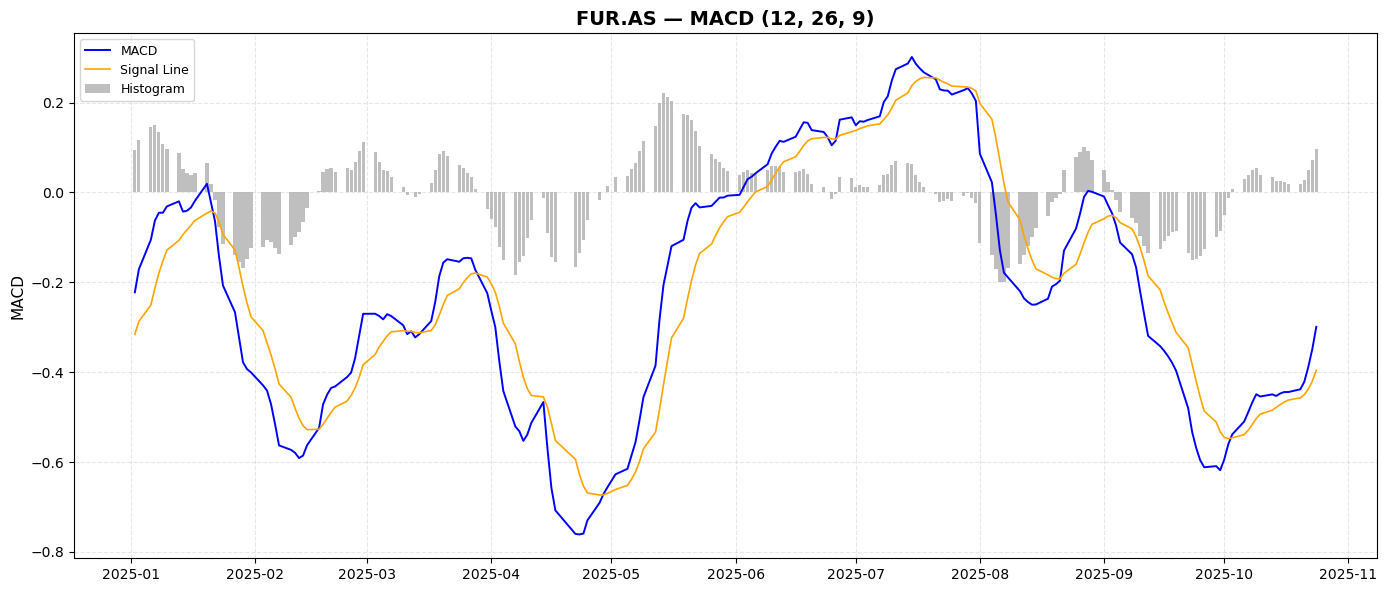

In [11]:
plot_macd(df, ticker, start_plot_date=start_plot_date)

## Technical coding

In [12]:
def analyze_technical_indicators(ticker,
                                 start_date="start_date",
                                 rsi_period=rsi_period,
                                 bb_period=20, bb_std_dev=2,
                                 macd_fast=12, macd_slow=26, macd_signal=9,
                                 ma_periods=periods):
    """
    Analyseert RSI, Bollinger Bands, MACD, SMA & EMA.
    Geeft een korte samenvatting + een 3-paneel-plot.
    """
    # ---------- 1. Data ----------
    close_df = df[['Close']].copy()

    # ---------- 2. Indicatoren berekenen ----------
    # SMA & EMA
    for p in ma_periods:
        close_df[f'SMA{p}'] = close_df['Close'].rolling(window=p).mean()
        close_df[f'EMA{p}'] = close_df['Close'].ewm(span=p, adjust=False).mean()

    # RSI (Wilder)
    delta = close_df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/rsi_period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/rsi_period, adjust=False).mean()
    rs = avg_gain / avg_loss
    close_df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    close_df['BB_Middle'] = close_df['Close'].rolling(window=bb_period).mean()
    close_df['BB_Std']    = close_df['Close'].rolling(window=bb_period).std()
    close_df['BB_Upper']  = close_df['BB_Middle'] + close_df['BB_Std'] * bb_std_dev
    close_df['BB_Lower']  = close_df['BB_Middle'] - close_df['BB_Std'] * bb_std_dev

    # MACD
    close_df['EMA_Fast'] = close_df['Close'].ewm(span=macd_fast, adjust=False).mean()
    close_df['EMA_Slow'] = close_df['Close'].ewm(span=macd_slow, adjust=False).mean()
    close_df['MACD']     = close_df['EMA_Fast'] - close_df['EMA_Slow']
    close_df['Signal']   = close_df['MACD'].ewm(span=macd_signal, adjust=False).mean()
    close_df['Histogram']= close_df['MACD'] - close_df['Signal']

    # Filter voor de plot
    plot_df = close_df[close_df.index >= start_plot_date].copy()

    # ---------- 3. Laatste waarden (numeriek) ----------
    last = close_df.iloc[-1]
    prev = close_df.iloc[-2] if len(close_df) > 1 else last

    # ---------- 4. Analyse (met .item()) ----------
    # RSI
    rsi_val = last['RSI'].item()
    if rsi_val > 70:
        rsi_status = "Overbought (mogelijk bearish, verkoopsignaal)"
    elif rsi_val < 30:
        rsi_status = "Oversold (mogelijk bullish, koopsignaal)"
    else:
        rsi_status = "Neutraal"

    # Bollinger Bands
    price = last['Close'].item()
    if price >= last['BB_Upper'].item():
        bb_status = "Boven bovenste band (mogelijk overbought, bearish)"
    elif price <= last['BB_Lower'].item():
        bb_status = "Onder onderste band (mogelijk oversold, bullish)"
    elif abs(price - last['BB_Upper'].item()) < abs(price - last['BB_Middle'].item()):
        bb_status = "Dicht bij bovenste band (bullish trend)"
    elif abs(price - last['BB_Lower'].item()) < abs(price - last['BB_Middle'].item()):
        bb_status = "Dicht bij onderste band (bearish trend)"
    else:
        bb_status = "Rond middenband (neutraal, consolidatie)"

    # MACD
    if last['MACD'].item() > last['Signal'].item() and last['Histogram'].item() > 0:
        macd_status = "Bullish (MACD boven signaallijn, koopsignaal)"
    elif last['MACD'].item() < last['Signal'].item() and last['Histogram'].item() < 0:
        macd_status = "Bearish (MACD onder signaallijn, verkoopsignaal)"
    else:
        macd_status = "Neutraal (geen duidelijke crossover)"

    # SMA / EMA + Golden/Death Cross
    above_all_sma = all(price > last[f'SMA{p}'].item() for p in ma_periods)
    below_all_sma = all(price < last[f'SMA{p}'].item() for p in ma_periods)
    above_all_ema = all(price > last[f'EMA{p}'].item() for p in ma_periods)
    below_all_ema = all(price < last[f'EMA{p}'].item() for p in ma_periods)

    cross = ""
    if prev['SMA50'].item() <= prev['SMA200'].item() and last['SMA50'].item() > last['SMA200'].item():
        cross = "Golden Cross (sterk bullish, koopsignaal)"
    elif prev['SMA50'].item() >= prev['SMA200'].item() and last['SMA50'].item() < last['SMA200'].item():
        cross = "Death Cross (sterk bearish, verkoopsignaal)"

    if above_all_sma and above_all_ema:
        ma_status = "Sterk bullish (koers boven alle SMA/EMA)"
    elif below_all_sma and below_all_ema:
        ma_status = "Sterk bearish (koers onder alle SMA/EMA)"
    elif above_all_sma or above_all_ema:
        ma_status = "Bullish (koers boven meeste SMA/EMA)"
    elif below_all_sma or below_all_ema:
        ma_status = "Bearish (koers onder meeste SMA/EMA)"
    else:
        ma_status = "Neutraal (koers tussen SMA/EMA)"

    if cross:
        ma_status += f", {cross}"

    # ---------- 5. Samenvatting ----------
    summary = f"""
Analyse voor **{ticker.upper()}** (laatste datum: {close_df.index[-1].strftime('%Y-%m-%d')}):
- RSI ({rsi_period}): {rsi_val:.2f} → **{rsi_status}**
- Bollinger Bands: **{bb_status}**
- MACD ({macd_fast},{macd_slow},{macd_signal}): **{macd_status}**
- SMA/EMA ({', '.join(map(str,ma_periods))}): **{ma_status}**
"""
    print(summary)

    # ---------- 6. Plot ----------
    colors = {20: "green", 50: "red", 200: "black"}
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10),
                                       sharex=True,
                                       gridspec_kw={'height_ratios': [2.5, 1, 1]})

    # Prijs + BB + SMA/EMA
    ax1.plot(plot_df.index, plot_df['Close'], color='blue', label='Close', linewidth=1.6)
    ax1.plot(plot_df.index, plot_df['BB_Middle'], color='orange', label=f'SMA{bb_period}', linewidth=1.2)
    ax1.plot(plot_df.index, plot_df['BB_Upper'], color='green', linestyle='--', label='Upper Band')
    ax1.plot(plot_df.index, plot_df['BB_Lower'], color='red',   linestyle='--', label='Lower Band')
    ax1.fill_between(plot_df.index, plot_df['BB_Upper'], plot_df['BB_Lower'],
                     color='gray', alpha=0.1)

    for p in ma_periods:
        ax1.plot(plot_df.index, plot_df[f'SMA{p}'], color=colors[p], label=f'SMA{p}', linewidth=1.2)
        ax1.plot(plot_df.index, plot_df[f'EMA{p}'], color=colors[p], linestyle='--', label=f'EMA{p}', linewidth=1.2)

    ax1.set_title(f"{ticker.upper()} — Prijs, Bollinger, SMA/EMA, RSI & MACD", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Prijs")
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.legend(loc='upper left', fontsize=9)
    ax1.yaxis.get_major_formatter().set_scientific(False)

    # RSI
    ax2.plot(plot_df.index, plot_df['RSI'], color='purple', label=f'RSI ({rsi_period})', linewidth=1.4)
    ax2.axhline(70, color='red', linestyle='--')
    ax2.axhline(30, color='green', linestyle='--')
    ax2.fill_between(plot_df.index, 70, 30, color='gray', alpha=0.1)
    ax2.set_ylabel("RSI")
    ax2.set_ylim(0, 100)
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.legend(loc='upper left', fontsize=9)

    # MACD
    ax3.plot(plot_df.index, plot_df['MACD'], color='blue', label='MACD', linewidth=1.4)
    ax3.plot(plot_df.index, plot_df['Signal'], color='orange', label='Signal', linewidth=1.2)
    ax3.bar(plot_df.index, plot_df['Histogram'], color='gray', alpha=0.5, label='Histogram')
    ax3.set_ylabel("MACD")
    ax3.grid(True, linestyle='--', alpha=0.3)
    ax3.legend(loc='upper left', fontsize=9)

    plt.tight_layout(pad=1)
    plt.show()

    return summary

## Summary output Technical analysis


Analyse voor **FUR.AS** (laatste datum: 2025-10-24):
- RSI (14): 47.78 → **Neutraal**
- Bollinger Bands: **Rond middenband (neutraal, consolidatie)**
- MACD (12,26,9): **Bullish (MACD boven signaallijn, koopsignaal)**
- SMA/EMA (20, 50, 200): **Neutraal (koers tussen SMA/EMA)**



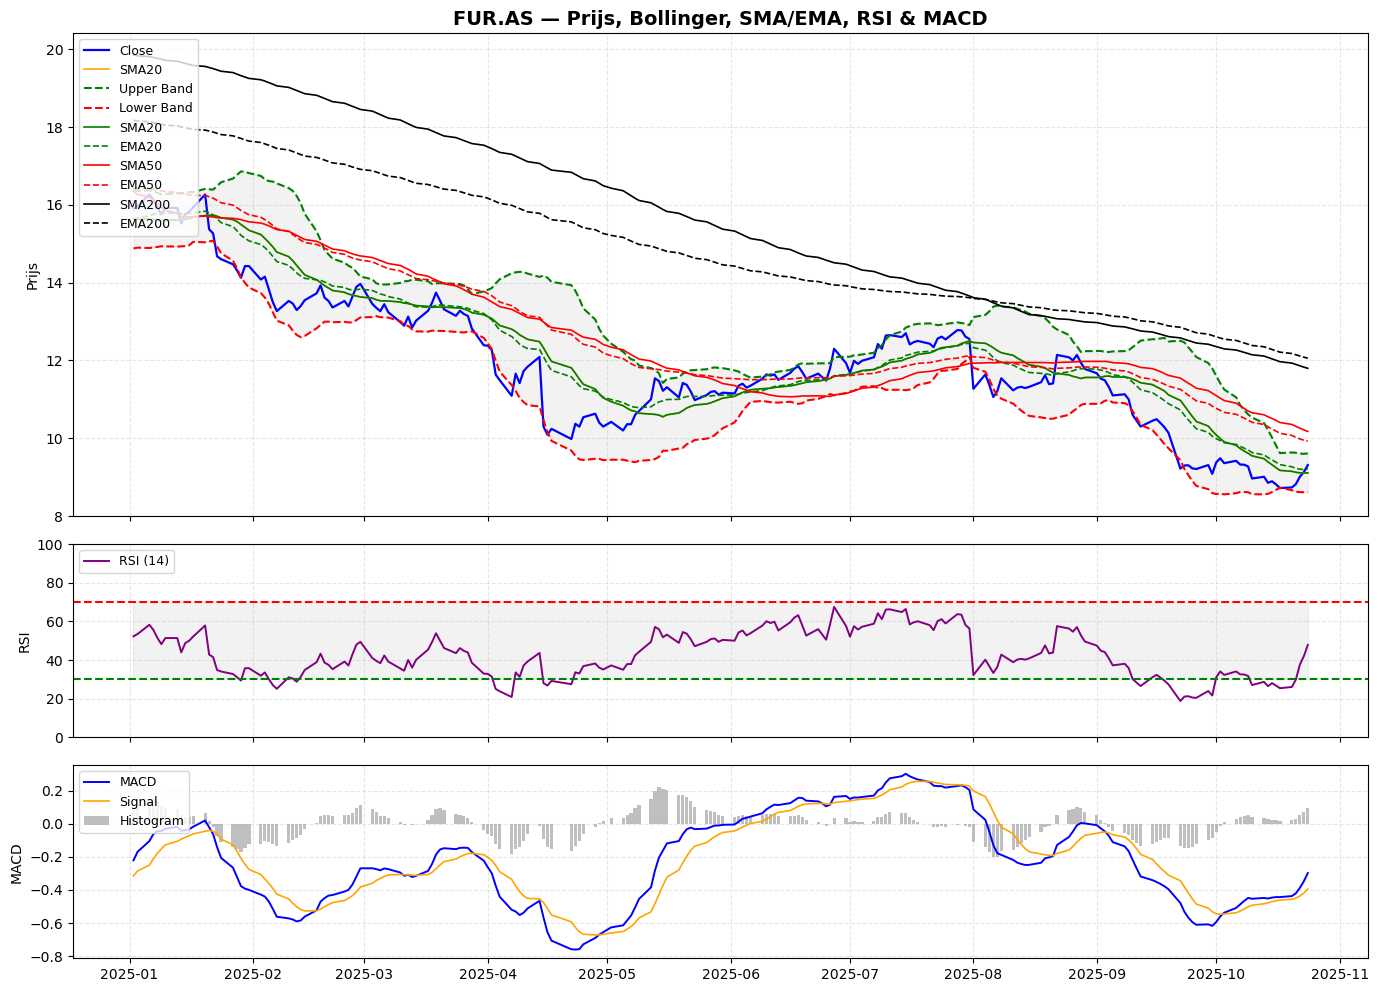

In [13]:
analyze_technical_indicators(ticker);

# Fugro:
- Sell order: EMA50, RSI +- 60.

## RSI Future predictor function coding

In [14]:
def plot_rsi_with_peaks_and_regression(df, rsi_period, start_plot_date, ticker, dof=1, n_toppen=3, future_days=30):
    """
    Plot RSI met toppen, gefilterde toppenlijn en regressielijnvoorspelling.
    
    Parameters:
    - df: DataFrame met 'Close'-kolom en optioneel 'RSI'-kolom
    - rsi_period: Aantal periodes voor RSI-berekening
    - start_plot_date: Startdatum voor de plot (in index van df)
    - ticker: Symbool van het aandeel voor de titel
    - dof: Graad van de polynoom voor regressie (standaard 1)
    - n_toppen: Aantal toppen voor regressie (standaard 3)
    - future_days: Aantal dagen voor toekomstvoorspelling (standaard 30)
    """
    # ---- Hergebruik RSI of bereken opnieuw ----
    if 'RSI' not in df.columns:
        df['RSI'] = calculate_rsi(df, rsi_period)

    # ---- Filter data voor plot ----
    plot_df = df[df.index >= start_plot_date].copy()
    rsi_values = plot_df['RSI'].values
    dates = plot_df.index

    # ---- Detecteer toppen en filter voor strakke lijnen ----
    peaks_idx, _ = find_peaks(rsi_values, prominence=6, distance=10)
    peak_dates = dates[peaks_idx]
    peak_values = rsi_values[peaks_idx]

    if len(peak_values) > 0:
        filtered_idx = [0]
        for i in range(1, len(peak_values)-1):
            prev_i, curr_i, next_i = i-1, i, i+1
            interp = peak_values[prev_i] + (peak_values[next_i] - peak_values[prev_i]) * \
                     (peak_dates[i] - peak_dates[prev_i]).days / (peak_dates[next_i] - peak_dates[prev_i]).days
            if peak_values[curr_i] >= interp:
                filtered_idx.append(i)
        filtered_idx.append(len(peak_values)-1)

        filtered_idx = sorted(set(filtered_idx))
        filtered_dates = peak_dates[filtered_idx]
        filtered_values = peak_values[filtered_idx]
    else:
        filtered_dates = np.array([])
        filtered_values = np.array([])

    # ---- Regressielijn voorspelling ----
    if len(filtered_values) >= n_toppen:
        filtered_peaks = list(zip(filtered_dates, filtered_values))
        selected_peaks = filtered_peaks[-n_toppen:]

        dates_num = np.array([(d - selected_peaks[0][0]).days for d, v in selected_peaks])
        rsi_values_selected = np.array([v for d, v in selected_peaks])

        coefs = np.polyfit(dates_num, rsi_values_selected, deg=dof)
        poly = np.poly1d(coefs)

        x_fit = np.linspace(dates_num[0], dates_num[-1] + future_days, 100)
        y_fit = poly(x_fit)
        fit_dates = [selected_peaks[0][0] + pd.Timedelta(days=int(x)) for x in x_fit]
    else:
        fit_dates = np.array([])
        y_fit = np.array([])

    # ---- Plot RSI + toppen + regressielijn ----
    plt.figure(figsize=(14, 5))
    plt.plot(dates, rsi_values, color='purple', linewidth=1.6, label=f'RSI ({rsi_period})')
    plt.axhline(70, color='red', linestyle='--', linewidth=1)
    plt.axhline(30, color='green', linestyle='--', linewidth=1)
    plt.fill_between(dates, 70, 30, color='gray', alpha=0.1)

    if len(filtered_values) > 0:
        plt.scatter(filtered_dates, filtered_values, color='green', s=70, label='Belangrijkste toppen')
    if len(filtered_values) >= 2:
        plt.plot(filtered_dates, filtered_values, color='darkgreen', linewidth=2.5, label='Toppenlijn')

    if len(fit_dates) > 0:
        plt.plot(fit_dates, y_fit, color='orange', linewidth=2, linestyle='--', 
                 label=f'Regressielijn (DOF={dof}, {n_toppen} toppen)')

    plt.title(f"{ticker} — RSI ({rsi_period}) met gefilterde toppenlijn en voorspelling", 
              fontsize=14, fontweight='bold')
    plt.ylabel("RSI")
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

## RSI predictor plot

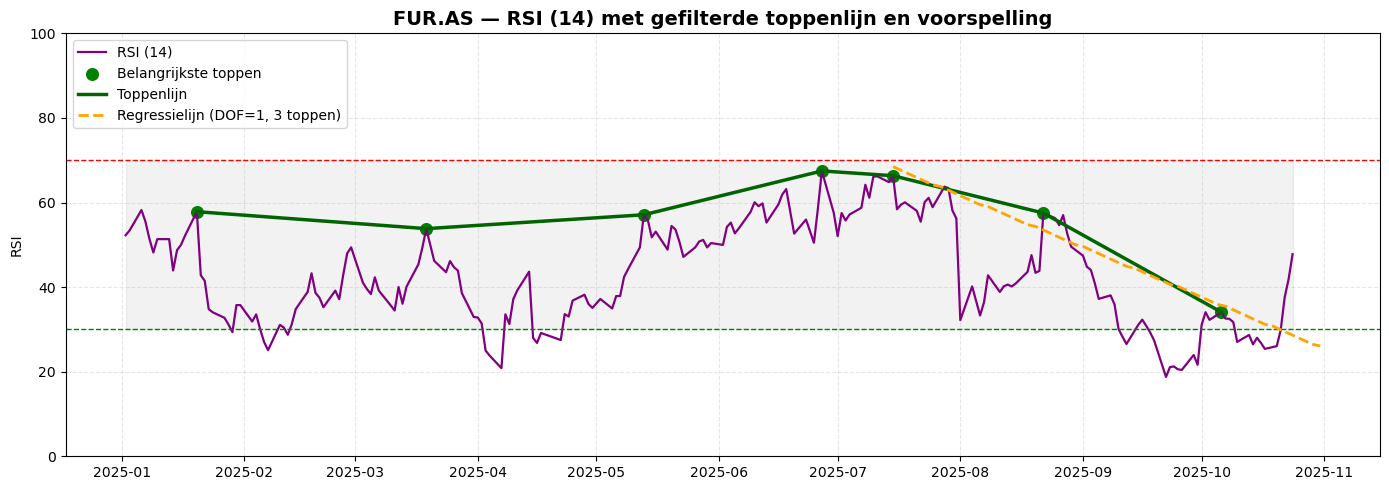

In [15]:
plot_rsi_with_peaks_and_regression(df, rsi_period, start_plot_date, ticker, dof=1, n_toppen=3, future_days=25)

## RSI custom top selection

In [16]:
def plot_rsi_with_peaks_and_regression2(df, rsi_period, start_plot_date, ticker, 
                                       dof=1, n_toppen=3, future_days=30, selected_peak_indices=None):
    """
    Plot RSI met toppen, gefilterde toppenlijn en regressielijnvoorspelling.
    Alle detecteerde toppen blijven zichtbaar (zwart), geselecteerde toppen groen.
    """
    # ---- Hergebruik RSI of bereken opnieuw ----
    if 'RSI' not in df.columns:
        df['RSI'] = calculate_rsi(df, rsi_period)

    # ---- Filter data voor plot ----
    plot_df = df[df.index >= start_plot_date].copy()
    rsi_values = plot_df['RSI'].values
    dates = plot_df.index

    # ---- Detecteer toppen ----
    peaks_idx, _ = find_peaks(rsi_values, prominence=6, distance=10)
    peak_dates = dates[peaks_idx]
    peak_values = rsi_values[peaks_idx]

    # ---- Filter toppen automatisch voor strakke lijnen ----
    if len(peak_values) > 0:
        filtered_idx = [0]
        for i in range(1, len(peak_values)-1):
            prev_i, curr_i, next_i = i-1, i, i+1
            interp = peak_values[prev_i] + (peak_values[next_i] - peak_values[prev_i]) * \
                     (peak_dates[i] - peak_dates[prev_i]).days / (peak_dates[next_i] - peak_dates[prev_i]).days
            if peak_values[curr_i] >= interp:
                filtered_idx.append(i)
        filtered_idx.append(len(peak_values)-1)
        filtered_idx = sorted(set(filtered_idx))
        filtered_dates = peak_dates[filtered_idx]
        filtered_values = peak_values[filtered_idx]
    else:
        filtered_dates = np.array([])
        filtered_values = np.array([])

    # ---- Handmatige selectie van toppen (optioneel) ----
    if selected_peak_indices is not None and len(filtered_values) > 0:
        # Validatie
        selected_peak_indices = [i for i in selected_peak_indices if i < len(filtered_dates)]
        selected_dates = filtered_dates[selected_peak_indices]
        selected_values = filtered_values[selected_peak_indices]
    else:
        selected_dates = np.array([])
        selected_values = np.array([])

    # ---- Regressielijn voorspelling ----
    if len(selected_values) >= 2:
        dates_num = np.array([(d - selected_dates[0]).days for d in selected_dates])
        coefs = np.polyfit(dates_num, selected_values, deg=dof)
        poly = np.poly1d(coefs)

        x_fit = np.linspace(dates_num[0], dates_num[-1] + future_days, 100)
        y_fit = poly(x_fit)
        fit_dates = [selected_dates[0] + pd.Timedelta(days=int(x)) for x in x_fit]
    else:
        fit_dates = np.array([])
        y_fit = np.array([])

    # ---- Plot ----
    plt.figure(figsize=(14, 5))
    plt.plot(dates, rsi_values, color='purple', linewidth=1.6, label=f'RSI ({rsi_period})')
    plt.axhline(70, color='red', linestyle='--', linewidth=1)
    plt.axhline(30, color='green', linestyle='--', linewidth=1)
    plt.fill_between(dates, 70, 30, color='gray', alpha=0.1)

    # ---- Alle toppen in zwart ----
    if len(filtered_values) > 0:
        plt.scatter(filtered_dates, filtered_values, color='black', s=50, label='Alle toppen')

    # ---- Geselecteerde toppen in groen ----
    if len(selected_values) > 0:
        plt.scatter(selected_dates, selected_values, color='green', s=70, label='Geselecteerde toppen')

    # ---- Toppenlijn (verbinding geselecteerde toppen) ----
    if len(selected_values) >= 2:
        plt.plot(selected_dates, selected_values, color='darkgreen', linewidth=2.5, label='Toppenlijn')

    # ---- Regressielijn ----
    if len(fit_dates) > 0:
        plt.plot(fit_dates, y_fit, color='orange', linewidth=2, linestyle='--', 
                 label=f'Regressielijn (DOF={dof})')

    plt.title(f"{ticker} — RSI ({rsi_period}) met toppen en regressielijn", 
              fontsize=14, fontweight='bold')
    plt.ylabel("RSI")
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


## RSI custom plot

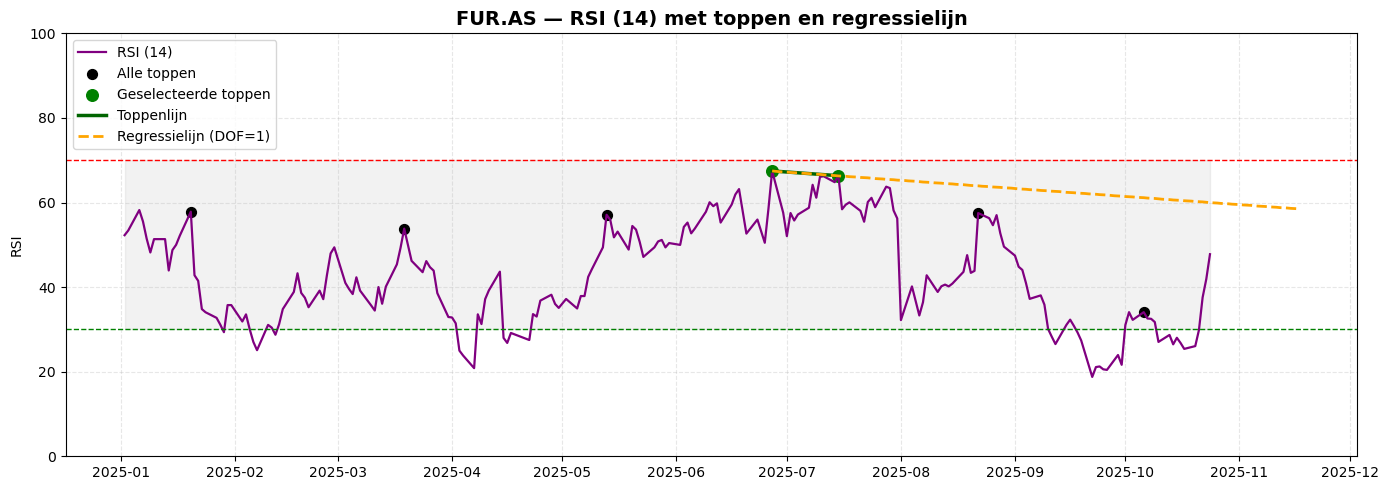

In [17]:
plot_rsi_with_peaks_and_regression2(df, rsi_period, start_plot_date, ticker, 
                                   dof=1, future_days=125, selected_peak_indices=[3, 4])


## TRYOUT

C:\Users\jarno\AppData\Local\Temp\ipykernel_14216\484591232.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, interval=interval)
[*********************100%***********************]  1 of 1 completed


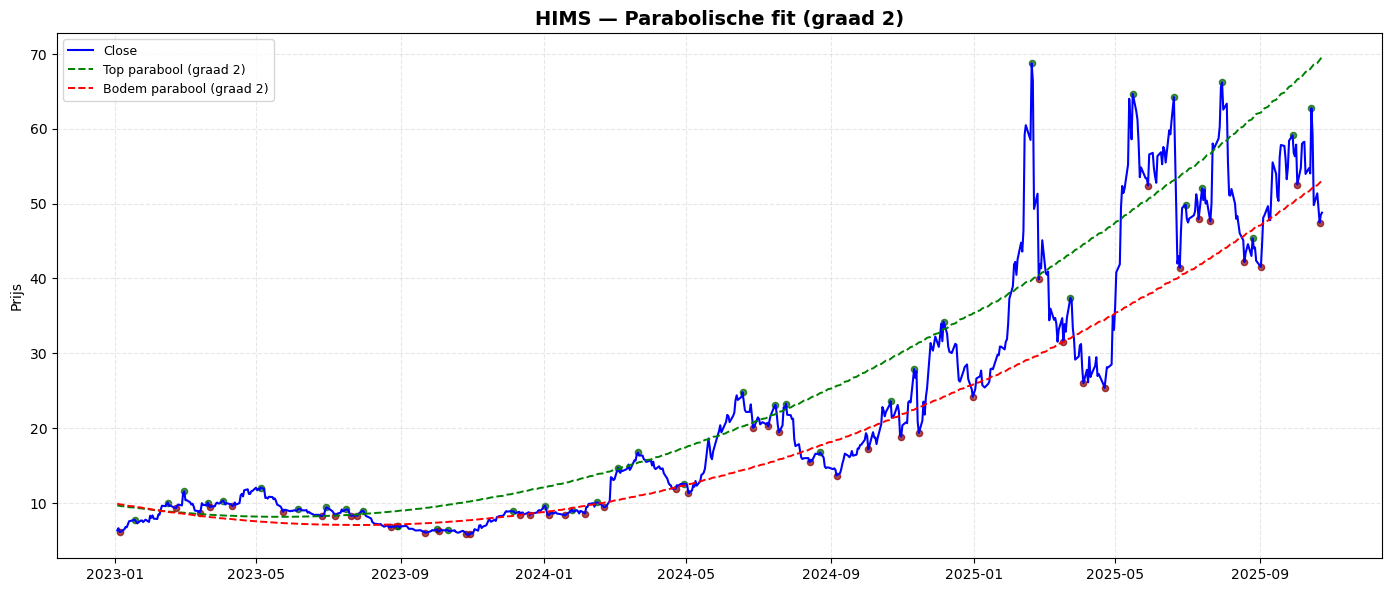

In [18]:
def plot_parabolic_fit(ticker, start="2023-01-01",
                       degree=2,
                       show_tops=True,
                       show_bottoms=True,
                       interval="1d"):
    """
    Plot een aandeel met optionele parabolische fit door toppen en/of dalen.
    - degree: graad van de parabool (2 = klassiek, 3 = cubic, ...)
    - show_tops / show_bottoms: True/False om ze aan/uit te zetten
    """

    # ---------- 1. Data ophalen ----------
    df = yf.download(ticker, start=start, interval=interval)
    if df.empty:
        print(f"Geen data voor {ticker}")
        return
    df = df[['Close']].copy()

    # ---------- 2. Lokale toppen en dalen vinden ----------
    order = 5  # hoe breed het venster is voor piekdetectie (5 = mild)
    df['max'] = df.iloc[argrelextrema(df['Close'].values, np.greater_equal, order=order)[0]]['Close']
    df['min'] = df.iloc[argrelextrema(df['Close'].values, np.less_equal, order=order)[0]]['Close']

    x = np.arange(len(df))

    # ---------- 3. Plot basisprijs ----------
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(df.index, df['Close'], color='blue', label='Close', linewidth=1.5)
    ax.set_title(f"{ticker} — Parabolische fit (graad {degree})", fontsize=14, fontweight='bold')
    ax.set_ylabel("Prijs")
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.yaxis.get_major_formatter().set_scientific(False)

    # ---------- 4. Fit door toppen ----------
    if show_tops and not df['max'].dropna().empty:
        x_tops = np.where(~np.isnan(df['max']))[0]
        y_tops = df['max'].dropna().values
        coeffs_top = np.polyfit(x_tops, y_tops, degree)
        poly_top = np.poly1d(coeffs_top)
        ax.plot(df.index, poly_top(x), color='green', linestyle='--', linewidth=1.4, label=f"Top parabool (graad {degree})")
        ax.scatter(df.index[x_tops], y_tops, color='darkgreen', s=20, alpha=0.7)

    # ---------- 5. Fit door dalen ----------
    if show_bottoms and not df['min'].dropna().empty:
        x_bottoms = np.where(~np.isnan(df['min']))[0]
        y_bottoms = df['min'].dropna().values
        coeffs_bottom = np.polyfit(x_bottoms, y_bottoms, degree)
        poly_bottom = np.poly1d(coeffs_bottom)
        ax.plot(df.index, poly_bottom(x), color='red', linestyle='--', linewidth=1.4, label=f"Bodem parabool (graad {degree})")
        ax.scatter(df.index[x_bottoms], y_bottoms, color='darkred', s=20, alpha=0.7)

    ax.legend(loc='upper left', fontsize=9)
    plt.tight_layout(pad=1)
    plt.show()


# Standaard, beide parabolen, kwadratisch
plot_parabolic_fit("HIMS", degree=2)

# Alleen toppen, cubic parabool
# plot_parabolic_fit("AAPL", degree=3, show_bottoms=False)

# # Alleen bodems, startend vanaf 2022
# plot_parabolic_fit("AAPL", start="2022-01-01", degree=2, show_tops=False)

